In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import numba
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numba import prange

In [2]:
@numba.jit(nopython=True)
def lorentz_dot(a, b):
    metric = np.array([-1, -1, -1, 1])  # Lorentzian metric signature (+, -, -, -)
    return np.dot(a*metric, b)
@numba.jit(nopython=True)
def boost(vector, boost_v):
    bx, by, bz = boost_v[0], boost_v[1], boost_v[2]
    b2 = bx**2 + by**2 + bz**2
    ggamma = 1.0 / np.sqrt(1.0 - b2)
    bp = bx * vector[0] + by * vector[1] + bz * vector[2]
    gamma2 = (ggamma - 1.0) / b2

    vector[0] += gamma2 * bp * bx + ggamma * bx * vector[3]
    vector[1] += gamma2 * bp * by + ggamma * by * vector[3]
    vector[2] += gamma2 * bp * bz + ggamma * bz * vector[3]
    vector[3] = ggamma * (vector[3] + bp)
    
    return vector
@numba.njit(parallel=True)
def calcVariables(mom):
    mmu=0.10566
    mp = 0.938
    ebeam = 120.0
    p_beam = np.array([0.0, 0.0, np.sqrt(ebeam*ebeam - mp*mp), ebeam])
    p_target = np.array([0.0, 0.0, 0.0, mp])
    p_cms = p_beam + p_target
    s = lorentz_dot(p_cms, p_cms)
    mass=np.zeros((len(mom)))
    pT=np.zeros((len(mom)))
    x1=np.zeros((len(mom)))
    x2=np.zeros((len(mom)))
    xF=np.zeros((len(mom)))
    costheta=np.zeros((len(mom)))
    sintheta=np.zeros((len(mom)))
    phi=np.zeros((len(mom)))
    for i in prange(len(mom)):
        momentum = mom[i]
        E_pos=np.sqrt(momentum[0]*momentum[0] + momentum[1]*momentum[1] + momentum[2]*momentum[2] + mmu*mmu);
        p_pos=np.array([momentum[0],momentum[1],momentum[2],E_pos])
        E_neg=np.sqrt(momentum[3]*momentum[3] + momentum[4]*momentum[4] + momentum[5]*momentum[5] + mmu*mmu);
        p_neg=np.array([momentum[3],momentum[4],momentum[5],E_neg])

        p_sum = p_pos + p_neg

        mass[i] = np.sqrt(lorentz_dot(p_sum, p_sum))
        pT[i] = np.sqrt(p_sum[0]**2+p_sum[1]**2)

        x1[i] = lorentz_dot(p_target, p_sum) / lorentz_dot(p_target, p_cms)
        x2[i] = lorentz_dot(p_beam, p_sum) / lorentz_dot(p_beam, p_cms)
        
        costheta[i] = 2.0 * (p_neg[3]*p_pos[2]-p_pos[3]*p_neg[2])/mass[i]/ np.sqrt(mass[i] * mass[i] + pT[i] * pT[i])
        xF[i] = 2.0 * p_sum[2] / np.sqrt(s) / (1.0 - mass[i] * mass[i] / s)
        phi[i] = np.arctan2(2.0 * np.sqrt(mass[i] * mass[i] + pT[i] * pT[i]) * (p_neg[0]*p_pos[1] - p_pos[0]*p_neg[1]), 
                         mass[i]*(p_pos[0]*p_pos[0] - p_neg[0]*p_neg[0] + p_pos[1]*p_pos[1] - p_neg[1]*p_neg[1]))
        sintheta[i]=np.sqrt(1-costheta[i]**2)
    return mass, pT, x1, x2, xF, costheta, sintheta, phi

kin_means = np.array([ 2.0, 0., 35., -2.0, 0., 35. ])
kin_stds = np.array([ 0.6, 1.2, 10, 0.6, 1.2, 10 ])

vertex_means=np.array([0,0,-300])
vertex_stds=np.array([10,10,300])

means = np.concatenate((kin_means,vertex_means))
stds = np.concatenate((kin_stds,vertex_stds))

# Read the list of good spills from the file
with open("list_spill_good.txt", "r") as file:
    good_spills = set(map(int, file.read().split()))

In [3]:
directory = '.'
# List all root files in the directory and its subdirectories
all_files = []
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith('reconstructed.npy'):
            all_files.append(os.path.join(root, file))
# Sort the lists alphabetically
all_files.sort()

In [4]:
# Concatenate files for each category
all_data = np.concatenate([np.load(file) for file in all_files], axis=0)
print(len(all_data))

19766426


In [5]:
dimu_prob = all_data[:,3]

prob_threshold = 0.75

# Filter based on the condition dimuon_probability[:, 3] > prob_threshold
filtered_indices = dimu_prob > prob_threshold
filtered_data = all_data[filtered_indices]

In [6]:
dimu_prob_filtered = dimu_prob[filtered_indices]

hits_missing = filtered_data[:,6]

all_vtx_pred = filtered_data[:,7:16]
z_vtx_pred = filtered_data[:,16:25]
target_pred = filtered_data[:,25:31]

target_prob = filtered_data[:,32]

metadata_filtered = filtered_data[:,33:]

runid = metadata_filtered[:,0]
eventid = metadata_filtered[:,1]
spillid = metadata_filtered[:,2]
trigger_bit = metadata_filtered[:,3]
target_type = metadata_filtered[:,4]
turnid = metadata_filtered[:,5]
rfit = metadata_filtered[:,6]
st1_occ = np.sum(metadata_filtered[:,45:51],axis=1)
st2_occ = np.sum(metadata_filtered[:,57:63],axis=1)
st3p_occ = np.sum(metadata_filtered[:,63:69],axis=1)
st3m_occ = np.sum(metadata_filtered[:,69:75],axis=1)
drift_occ = st1_occ+st2_occ+st3p_occ+st3m_occ
intensity = np.sum(metadata_filtered[:,11:36],axis=1)
good_spill_mask = np.isin(spillid, list(good_spills))

fpga1=metadata_filtered[:,3]==1
hydrogen = metadata_filtered[:,4]==1
flask = metadata_filtered[:,4]==2
deuterium = metadata_filtered[:,4]==3
none = metadata_filtered[:,4]==4
iron = metadata_filtered[:,4]==5
carbon = metadata_filtered[:,4]==6
tungsten = metadata_filtered[:,4]==7

In [26]:
mass, pT, x1, x2, xF, costheta, sintheta, phi = calcVariables(z_vtx_pred)

occ_cuts = (st1_occ<320) & (st2_occ<160) & (st3p_occ+st3m_occ<150) & (st3m_occ<150)

x_cuts = (x1-x2>-0.1) & (x1-x2<0.9) & (x2>0.05)

track_cuts = (abs(z_vtx_pred[:,1])>0.02)&(abs(z_vtx_pred[:,4])>0.02)
dimu_kin = z_vtx_pred[:,:3]+z_vtx_pred[:,3:6]
dimuon_cuts = ((abs(dimu_kin[:,0])<1.8) & (abs(dimu_kin[:,1])<2)&
              (abs(dimu_kin[:,2]-77)<39) & (dimu_kin[:,0]**2+dimu_kin[:,1]**2<25)
              &track_cuts)
beamline = (all_vtx_pred[:,6]**2+(all_vtx_pred[:,7]-1.6)**2 < 9)&dimuon_cuts

target = dimuon_cuts & (target_prob>0.) & fpga1 & good_spill_mask & beamline & (hits_missing<=6)

filt = beamline & good_spill_mask & target & fpga1 & (intensity<8000) & occ_cuts & x_cuts

Mean of the Gaussian fit: 3.114 GeV
Width (sigma) of the Gaussian fit: 0.247 GeV


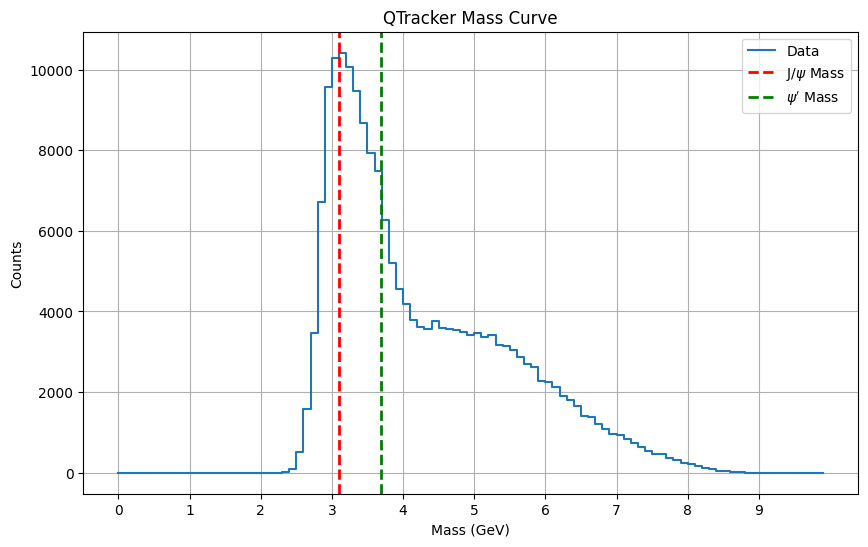

In [27]:
kinematics = z_vtx_pred[filt]
mass, pT, x1, x2, xF, costheta, sintheta, phi = calcVariables(kinematics)

plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.xticks(np.arange(0, 10, 1))
plt.grid()

# Add vertical lines at J/psi and psi prime masses
jpsi_mass = 3.0969  # J/psi mass in GeV
psiprime_mass = 3.6861  # Psi prime mass in GeV

# Assuming you have a function to define a Gaussian
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)

# Plot the histogram
hist, bin_edges= np.histogram(mass, bins=np.linspace(0, 10.0, 101))
plt.step(bin_edges[:-1], hist, where='post', label='Data')
#plt.yscale('log')
#plt.ylim(0.8,2*max(hist))
# Find the bin center for fitting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Define the range for the fit (up to 3.3 GeV)
fit_range = (bin_centers < 3.3)

# Fit the J/psi peak to a Gaussian using curve_fit on individual data points
initial_guess = [max(hist), jpsi_mass, 0.1]  # Amplitude, mean, stddev

# Select data points within the fit range
x_fit_data = bin_centers[fit_range]
y_fit_data = hist[fit_range]

# Fit the Gaussian
params, covariance = curve_fit(gaussian, x_fit_data, y_fit_data, p0=initial_guess)

# Print the mean and width of the Gaussian
mean_fit, width_fit = params[1], abs(params[2])
print(f"Mean of the Gaussian fit: {mean_fit:.3f} GeV")
print(f"Width (sigma) of the Gaussian fit: {width_fit:.3f} GeV")

# Plot the fitted Gaussian
x_fit = np.linspace(0, 3.3, 1000)
#plt.plot(x_fit, gaussian(x_fit, *params), 'r-', label='Gaussian Fit')

# Add vertical lines at J/psi and psi prime masses
plt.axvline(jpsi_mass, color='red', linestyle='dashed', linewidth=2, label='J/$\psi$ Mass')
plt.axvline(psiprime_mass, color='green', linestyle='dashed', linewidth=2, label='$\psi \'$ Mass')

plt.title('QTracker Mass Curve')
plt.xlabel('Mass (GeV)')
plt.ylabel('Counts')
#plt.yscale('log')
#plt.ylim(0.5,1.5*max(hist))

# Show the legend
plt.legend()

# Show the plot
plt.show()

dy_kinematics = kinematics[(mass>4.5)] 

In [10]:
mass_acceptance = np.zeros(20)
for i in range(20):
    low = 0.5*i
    high = 0.5*i+1
    print(i*0.5,np.std(target_prob[(mass>low)&(mass<high)]))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 19766426 but corresponding boolean dimension is 51874

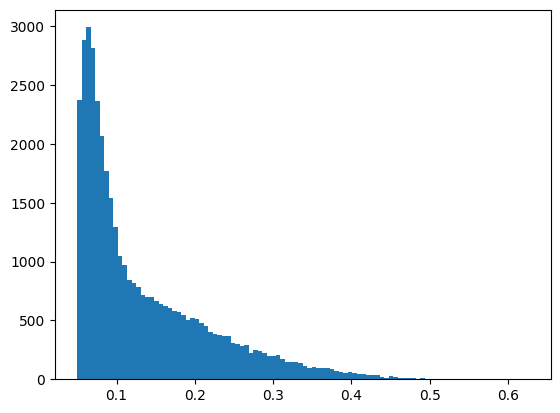

In [259]:
plt.hist(x2,bins=100)
plt.show()

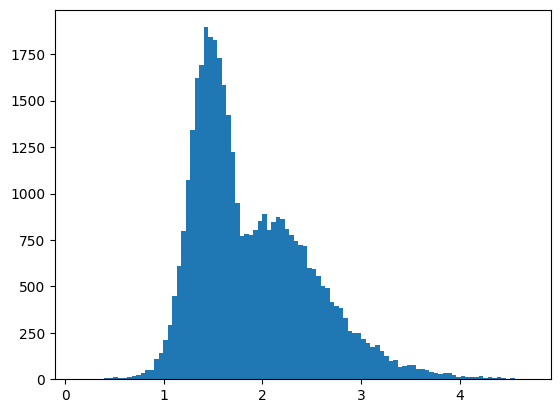

In [260]:
plt.hist(z_vtx_pred[:,0][filt],bins=100)
plt.show()

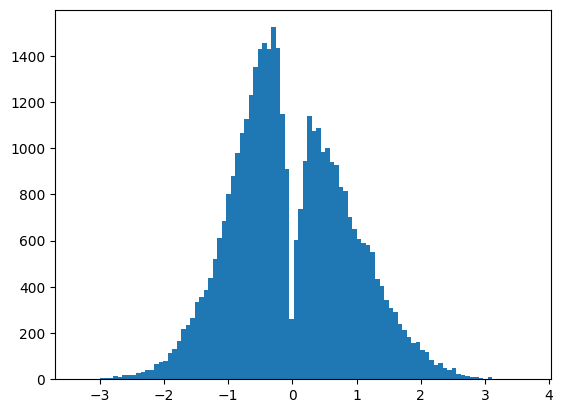

In [261]:
plt.hist(z_vtx_pred[:,1][filt],bins=100)
plt.show()

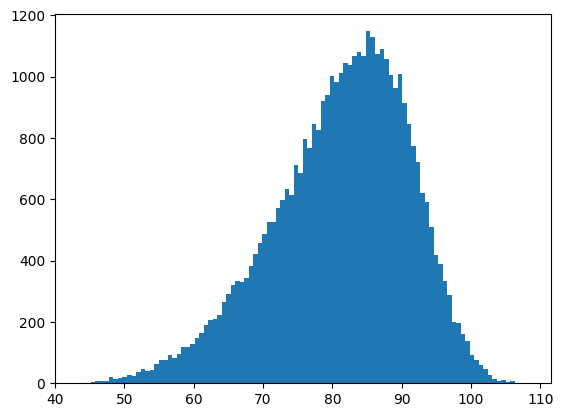

In [262]:
plt.hist((z_vtx_pred[:,2]+z_vtx_pred[:,5])[filt],bins=100)
plt.show()